In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn import model_selection

In [2]:
import bin_tree

# ДЗ №4 Гладышев В.В.

## Задание № 1

В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [3]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 3, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

In [4]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

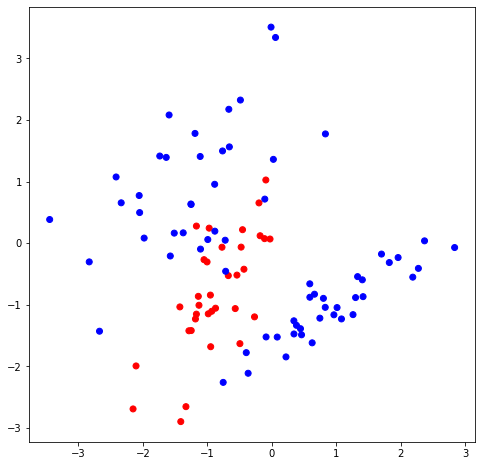

In [5]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [6]:
my_tree = bin_tree.build_tree(train_data, train_labels)
bin_tree.print_tree(my_tree)

Индекс 0
Порог 0.025099397110333044
--> True:
  Индекс 1
  Порог -0.42207293990104255
  --> True:
    Индекс 1
    Порог -1.427809833112875
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог -0.4866631767855123
    --> True:
      Индекс 1
      Порог 0.2779823563698063
      --> True:
        Индекс 0
        Порог -1.1058591883334556
        --> True:
          Прогноз: 2
        --> False:
          Прогноз: 2
      --> False:
        Прогноз: 2
    --> False:
      Прогноз: 0
--> False:
  Прогноз: 1


In [7]:
train_answers = bin_tree.predict(train_data, my_tree)
answers = bin_tree.predict(test_data, my_tree)
train_accuracy = bin_tree.accuracy_metric(train_labels, train_answers)
train_accuracy

87.14285714285714

In [8]:
test_accuracy = bin_tree.accuracy_metric(test_labels, answers)
test_accuracy

73.33333333333333

Text(0.5, 1.0, 'Test accuracy=73.33')

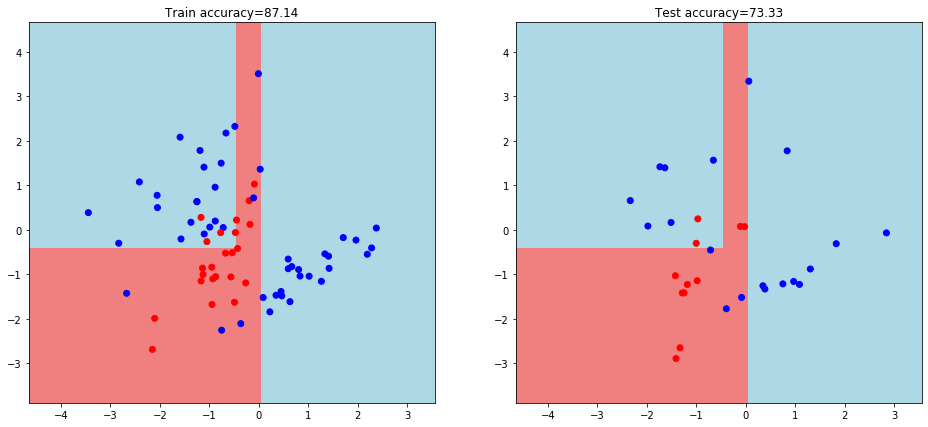

In [9]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = bin_tree.get_meshgrid(train_data)
mesh_predictions = np.array(bin_tree.predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построение дерева "ярусами"

In [10]:
class Branch:

    def __init__(self, data, labels, node, side):
        self.data = data
        self.labels = labels
        self.node = node
        self.side = side

In [11]:
def make_floor(in_branch_data_list):
    out_branch_list = []
    last_node_leaf = 0
    leaf_cnt = 0
    
    for br in in_branch_data_list:
        quality, t, index = bin_tree.find_best_split(br.data, br.labels)

        if quality == 0:    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
            last_node_leaf = bin_tree.Leaf(br.data, br.labels)
            leaf_cnt += 1
        else:
            true_data, false_data, true_labels, false_labels = bin_tree.split(br.data, br.labels, index, t)
            last_node_leaf = bin_tree.Node(index, t, 0, 0)
            out_branch_list.append(Branch(true_data, true_labels, last_node_leaf, True))
            out_branch_list.append(Branch(false_data, false_labels, last_node_leaf, False))
        if br.side:
            br.node.true_branch = last_node_leaf
        else:
            br.node.false_branch = last_node_leaf

    if out_branch_list:
        pr_node, leaf_cnt_pr = make_floor(out_branch_list)
        leaf_cnt += leaf_cnt_pr
    
    return last_node_leaf, leaf_cnt

In [12]:
my_tree_fl, leaves = make_floor(list([Branch(train_data, train_labels, bin_tree.Node(0, 0, 0, 0), True)]))

In [13]:
bin_tree.print_tree(my_tree_fl)

Индекс 0
Порог 0.025099397110333044
--> True:
  Индекс 1
  Порог -0.42207293990104255
  --> True:
    Индекс 1
    Порог -1.427809833112875
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог -0.4866631767855123
    --> True:
      Индекс 1
      Порог 0.2779823563698063
      --> True:
        Индекс 0
        Порог -1.1058591883334556
        --> True:
          Прогноз: 2
        --> False:
          Прогноз: 2
      --> False:
        Прогноз: 2
    --> False:
      Прогноз: 0
--> False:
  Прогноз: 1


In [14]:
print("Листьев: {}".format(leaves))

Листьев: 7


a) Ограничение на количество листьев

In [15]:
def build_tree_leaf_lim_tr(data, labels, leaf_lim = 100, leaves = 0, br = 0):
    
    quality, t, index = bin_tree.find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or (leaf_lim - leaves - br) < 2:
        leaves += 1
        return bin_tree.Leaf(data, labels), leaves, br

    true_data, false_data, true_labels, false_labels = bin_tree.split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    br += 1
    true_branch, leaves, br = build_tree_leaf_lim_tr(true_data, true_labels, leaf_lim, leaves, br)
    br -= 1
    false_branch, leaves, br = build_tree_leaf_lim_tr(false_data, false_labels, leaf_lim, leaves, br)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return bin_tree.Node(index, t, true_branch, false_branch), leaves, br

In [16]:
my_tree_ll_tr, leaves, br = build_tree_leaf_lim_tr(train_data, train_labels, 4)

In [17]:
bin_tree.print_tree(my_tree_ll_tr)

Индекс 0
Порог 0.025099397110333044
--> True:
  Индекс 1
  Порог -0.42207293990104255
  --> True:
    Индекс 1
    Порог -1.427809833112875
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Прогноз: 2
--> False:
  Прогноз: 1


In [18]:
print("Листьев: {}".format(leaves))

Листьев: 4


In [19]:
train_answers = bin_tree.predict(train_data, my_tree_ll_tr)
answers = bin_tree.predict(test_data, my_tree_ll_tr)
train_accuracy = bin_tree.accuracy_metric(train_labels, train_answers)
train_accuracy

84.28571428571429

In [20]:
test_accuracy = bin_tree.accuracy_metric(test_labels, answers)
test_accuracy

66.66666666666666

Text(0.5, 1.0, 'Test accuracy=66.67')

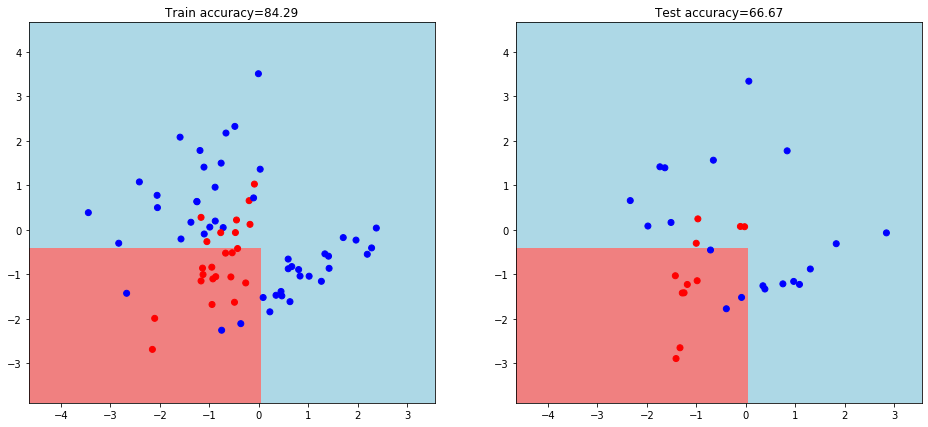

In [21]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = bin_tree.get_meshgrid(train_data)
mesh_predictions = np.array(bin_tree.predict(np.c_[xx.ravel(), yy.ravel()], my_tree_ll_tr)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

б) Ограничение на глубину дерева

In [22]:
def build_tree_depth_lim(data, labels, depth_lim = 20, depth = 0):
    
    quality, t, index = bin_tree.find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or depth >= depth_lim:
        #print(depth)
        return bin_tree.Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = bin_tree.split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_depth_lim(true_data, true_labels, depth_lim, depth + 1)
    false_branch = build_tree_depth_lim(false_data, false_labels, depth_lim, depth + 1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return bin_tree.Node(index, t, true_branch, false_branch)

In [23]:
my_tree_dl = build_tree_depth_lim(train_data, train_labels, 1)

In [24]:
bin_tree.print_tree(my_tree_dl)

Индекс 0
Порог 0.025099397110333044
--> True:
  Прогноз: 2
--> False:
  Прогноз: 1


In [25]:
train_answers = bin_tree.predict(train_data, my_tree_dl)
answers = bin_tree.predict(test_data, my_tree_dl)
train_accuracy = bin_tree.accuracy_metric(train_labels, train_answers)
train_accuracy

64.28571428571429

In [26]:
test_accuracy = bin_tree.accuracy_metric(test_labels, answers)
test_accuracy

46.666666666666664

Text(0.5, 1.0, 'Test accuracy=46.67')

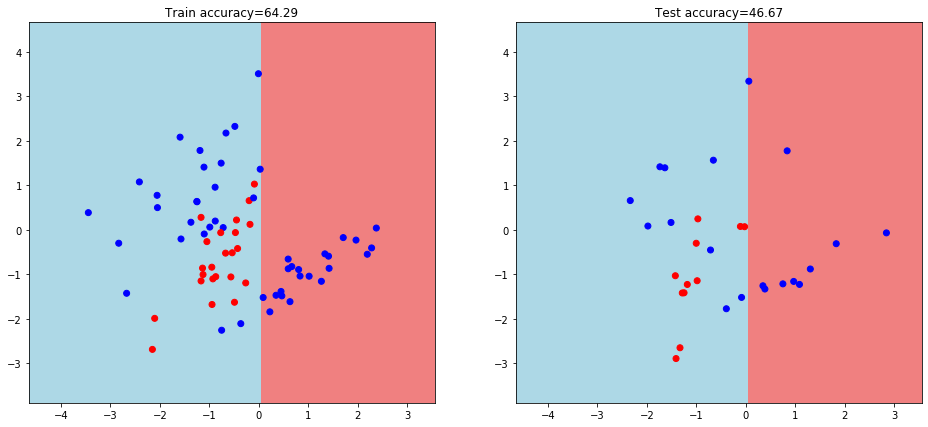

In [27]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = bin_tree.get_meshgrid(train_data)
mesh_predictions = np.array(bin_tree.predict(np.c_[xx.ravel(), yy.ravel()], my_tree_dl)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## Задание № 2

Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [28]:
class Leaf_Reg:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction 

In [29]:
def quality_reg(left_labels, right_labels, current_variance):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_variance - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [38]:
def find_best_split_reg(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_variance = np.var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = bin_tree.split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_reg(true_labels, false_labels, current_variance)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [39]:
def build_tree_reg(data, labels):

    quality, t, index = find_best_split_reg(data, labels)
    print("q: {} t: {} ind: {}".format(quality, t, index))

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf_Reg(data, labels)

    true_data, false_data, true_labels, false_labels = bin_tree.split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_reg(true_data, true_labels)
    false_branch = build_tree_reg(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return bin_tree.Node(index, t, true_branch, false_branch)

In [40]:
def pred_item(item, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf_Reg):
        answer = node.prediction
        return answer

    if item[node.index] <= node.t:
        return pred_item(item, node.true_branch)
    else:
        return pred_item(item, node.false_branch)

In [41]:
def predict_reg(data, tree):
    res = []
    for item in data:
        prediction = pred_item(item, tree)
        res.append(prediction)
    return res

In [42]:
def print_tree_reg(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf_Reg):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree_reg(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree_reg(node.false_branch, spacing + "  ")

In [43]:
X = np.array([[1, 1, 2, 1, 3, 0, 5, 10, 1, 2, 1, 1, 2, 1, 3, 0, 5, 10, 1, 2, 1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000, 
              500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000, 
              500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2, 1, 1, 2, 1, 2, 1, 3, 3, 1, 2, 1, 1, 2, 1, 2, 1, 3, 3, 1, 2]])
y = np.array([45, 55, 50, 59, 65, 35, 75, 80, 50, 60, 
              45, 55, 50, 59, 65, 35, 75, 80, 50, 60, 
              45, 55, 50, 59, 65, 35, 75, 80, 50, 60])
X = X.T
#y = y.reshape(len(y), 1)

In [44]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 1)

In [45]:
reg_tree = build_tree_reg(train_data, train_labels)

q: 114.51530612244899 t: 2 ind: 0
q: 10.80255681818182 t: 750 ind: 1
q: 0.0068870523415940355 t: 600 ind: 1
q: 0 t: None ind: None
q: 0 t: None ind: None
q: 0 t: None ind: None
q: 0 t: None ind: None


In [46]:
print_tree_reg(reg_tree)

Индекс 0
Порог 2
--> True:
  Индекс 1
  Порог 750
  --> True:
    Индекс 1
    Порог 600
    --> True:
      Прогноз: 52.166666666666664
    --> False:
      Прогноз: 52.0
  --> False:
    Прогноз: 45.0
--> False:
  Прогноз: 75.0


In [47]:
train_answers = predict_reg(train_data, reg_tree)

In [48]:
answers = predict_reg(test_data, reg_tree)

In [49]:
def mserror(y, y_pred):
    return np.mean((y - y_pred)**2)

In [50]:
mserror(train_labels, train_answers)

51.849206349206355

In [51]:
mserror(test_labels, answers)

67.60185185185185